In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time


def plu(x, alpha=0.1, c=1.0):
    return torch.maximum(alpha * (x + c) - c, torch.minimum(x, alpha * (x - c) + c))

# Use all available GPUs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def maybe_wrap_model(model):
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
        model = nn.DataParallel(model)
    return model

class SharedCNNLayer(nn.Module):
    def __init__(self, C, X, W, dropout):
        super().__init__()
        if X % 2 != 0:
            raise ValueError("X should be even to disallow zero-offset message travel.")
        self.C = C
        self.X = X
        self.W = W
        in_channels = C + X
        out_channels = C + 1
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=W, padding=0, bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, aux_inputs):
        x = torch.cat([features, aux_inputs], dim=1)
        x = self.circular_pad_1d(x, self.W)
        out = self.conv(x)
        feature_out = torch.tanh(out[:, :-1, :])  # tanh
        feature_out = self.dropout(feature_out)

        aux_out = out[:, -1, :]
        return feature_out, aux_out

    def circular_pad_1d(self, x, kernel_size):
        pad = kernel_size // 2
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size should be odd for symmetric circular padding.")
        return torch.cat([x[..., -pad:], x, x[..., :pad]], dim=-1)


class DeepCNN(nn.Module):
    def __init__(self, C, X, W, N, H, dropout):
        super().__init__()
        self.C = C
        self.X = X
        self.W = W
        self.N = N
        self.H = H
        self.shared_layer = SharedCNNLayer(C, X, W, dropout)

    def forward(self, aux_inputs):
        B, H, X, N = aux_inputs.shape
        features = torch.zeros(B, self.C, N, device=aux_inputs.device)
        aux_outputs = []
        hidden_rms = []
        for h in range(H):
            aux_in = aux_inputs[:, h, :, :]
            features, aux_out = self.shared_layer(features, aux_in)
            aux_outputs.append(aux_out.unsqueeze(1))
            hidden_rms.append((features ** 2).mean(dim=1).sqrt().unsqueeze(1))
        return torch.cat(aux_outputs, dim=1), torch.cat(hidden_rms, dim=1)


def train_model_until_convergence(model, H, N, X, M, batch_size=32, lr=0.001, pos_weight=20.0, patience=5, max_epochs=500, l1_lambda=0.001, ignore_layers=5):
    from IPython.display import clear_output, display
    import ipywidgets as widgets

    out = widgets.Output()
    display(out)
    status_out = widgets.Output()
    display(status_out)
    fig, ax = plt.subplots(figsize=(6, 4))
    losses = []

    model = maybe_wrap_model(model)
    model.to(device)

    print(f"Using batch size: {batch_size}")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = torch.amp.GradScaler()

    best_loss = float('inf')
    best_state = None
    epochs_without_improvement = 0

    ax.clear()
    line, = ax.plot(losses, label='Training Loss')
    ax.margins(x=0)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss Curve')
    ax.legend()
    ax.grid(True)

    for epoch in range(max_epochs):
        timings = {}
        t0 = time.time()
        aux_inputs, target_aux_outputs = generate_message_data(H, N, X, M, batch_size=batch_size, device=device)
        timings['data_gen'] = time.time() - t0

        t1 = time.time()
        model.train()
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            pred_aux, _ = model(aux_inputs)
            loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight, device=pred_aux.device))
            loss = loss_fn(pred_aux[:, ignore_layers:, :], target_aux_outputs[:, ignore_layers:, :])
        timings['forward'] = time.time() - t1

        t2 = time.time()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        timings['backward'] = time.time() - t2

        loss_val = loss.item()
        losses.append(loss_val)

        if epoch % 10 == 0 or epoch == max_epochs - 1:
            line.set_data(range(len(losses)), losses)
            ax.relim()
            ax.autoscale_view(True,True,True)
            fig.canvas.draw_idle()
            with out:
                out.clear_output(wait=True)
                display(fig)
        epoch_time = time.time() - t0

        if loss_val < best_loss:
            best_loss = loss_val
            best_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epoch % 10 == 0:
            with status_out:
                status_out.clear_output(wait=True)
                print(f"Epoch {epoch}: Loss = {loss_val:.4f}, Best Loss = {best_loss:.4f}, Total Time = {epoch_time:.2f}s | Data: {timings['data_gen']:.2f}s, Forward: {timings['forward']:.2f}s, Backward: {timings['backward']:.2f}s")

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch}. Best loss: {best_loss:.4f}")
            break

    if best_state:
        model.load_state_dict(best_state)

    return model


def run_inference(model, aux_inputs):
    model.to(device)
    aux_inputs = aux_inputs.to(device)
    model.eval()
    with torch.no_grad():
        logits, hidden_rms = model(aux_inputs)
        preds = torch.sigmoid(logits)
    return preds.cpu(), hidden_rms.cpu()


def visualize_validation_output(aux_inputs, aux_outputs, hidden_rms, green_threshold=0.8):
    aux_in = aux_inputs[0].cpu()
    aux_out = aux_outputs[0]
    rms = hidden_rms[0]
    H, X, N = aux_in.shape

    img = np.zeros((H, N, 3), dtype=np.float32)

    gray = aux_out.numpy()[:, :, None]
    rms_np = rms.numpy()
    rms_np = rms_np / (rms_np.max() + 1e-8)
    pink = np.stack([rms_np, np.zeros_like(rms_np), rms_np], axis=2)
    img += 0.5 * gray.repeat(3, axis=2) + 0.5 * pink

    fig, ax = plt.subplots()
    ax.imshow(img, aspect='auto')

    for t in range(H):
        for n in range(N):
            val = aux_out[t, n].item()
            if val > green_threshold:
                rect = plt.Rectangle(
                    (n - 0.5, t - 0.5), 1, 1,
                    linewidth=1,
                    edgecolor=(0, val, 0),
                    facecolor='none')
                ax.add_patch(rect)

    for x in range(X):
        for t in range(H):
            for n in range(N):
                if aux_in[t, x, n] > 0:
                    offset = x - (X // 2)
                    if offset >= 0:
                        offset += 1
                    t_out = t + abs(offset)
                    n_out = (n + offset) % N
                    if 0 <= t_out < H:
                        ax.annotate('', xy=(n_out, t_out), xytext=(n, t),
                                    arrowprops=dict(facecolor='white', edgecolor='white', arrowstyle='->'))

    ax.set_xlabel("N")
    ax.set_ylabel("H")
    ax.set_title("Validation Output\nGreen = Aux Output, White Arrows = Messages, Pink = Hidden RMS")
    plt.show()

def generate_message_data(H, N, X, M, batch_size=1, device=device, T=0):
    if X % 2 != 0:
        raise ValueError("X must be even to disallow zero-offset message travel.")

    aux_inputs = torch.zeros(batch_size, H, X, N, device=device)
    aux_outputs = torch.zeros(batch_size, H, N, device=device)

    total = batch_size * M
    b = torch.randint(0, batch_size, (total,), device=device)
    T_msg = torch.randint(0, H, (total,), device=device)
    P = torch.randint(0, N, (total,), device=device)

    D_choices = list(range(X))
    D = torch.tensor(np.random.choice(D_choices, size=total), device=device)

    offset = D - (X // 2)
    offset[offset >= 0] += 1
    T_out = T_msg + offset.abs() + T
    P_out = (P + offset) % N

    mask = T_out < H
    b, T_msg, D, P, T_out, P_out = b[mask], T_msg[mask], D[mask], P[mask], T_out[mask], P_out[mask]

    aux_inputs[b, T_msg, D, P] = 1.0
    aux_outputs[b, T_out, P_out] = 1.0

    return aux_inputs, aux_outputs


def summarize_messages(aux_inputs, aux_outputs):
    B, H, X, N = aux_inputs.shape
    for b in range(B):
        print(f"\nBatch {b}:")
        triggers = []
        receives = []

        for t in range(H):
            for x in range(X):
                for p in range(N):
                    if aux_inputs[b, t, x, p] > 0:
                        triggers.append((t, p, x))
            for p in range(N):
                if aux_outputs[b, t, p] > 0:
                    receives.append((t, p))

        print("  Messages triggered at:")
        for trig in triggers:
            print(f"    (T={trig[0]}, P={trig[1]}, X={trig[2]})")

        print("  Messages received at:")
        for rec in receives:
            print(f"    (T={rec[0]}, P={rec[1]})")


In [ ]:
class SharedGNNLayer(nn.Module):
    """
    One layer of graph convolution + per-node aux-out.
    - features:  (B, C, N)
    - aux_inputs: (B, X, N)
    """
    def __init__(self, C, X, W, dropout):
        super().__init__()
        self.C = C
        self.X = X
        self.W = W
        # we'll map (C + X) → (C + 1) per node after neighborhood aggregation
        self.lin = nn.Linear(C + X, C + 1, bias=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, aux_inputs):
        # features: B×C×N, aux_inputs: B×X×N, adj: N×N
        B, C, N = features.shape
        _, X, _ = aux_inputs.shape

        # 1) Concatenate latent + input features per node
        x = torch.cat([features, aux_inputs], dim=1)      # B×(C+X)×N
        x = x.permute(0, 2, 1)                            # B×N×(C+X)

        # 2) Neighborhood sum: h_i = Σ_j A[i,j] · x_j
        #    (batch-wise matmul)
        adj = self.make_ring_adj(N, pad=self.W//2, self_loops=True).to(x.device)  # N×N
        h = torch.matmul(adj, x)                          # B×N×(C+X)

        # 3) Linear transform on each node
        out = self.lin(h)                                 # B×N×(C+1)

        # 4) Split into next–features and aux_out
        feature_out = torch.tanh(out[..., :C])            # B×N×C
        feature_out = self.dropout(feature_out)
        aux_out     = out[...,  C]                        # B×N

        # back to channels-first for features
        feature_out = feature_out.permute(0, 2, 1)        # B×C×N
        return feature_out, aux_out

    def make_ring_adj(self, N, pad, self_loops=False):
        idx = torch.arange(N)
        diff = idx.view(N,1) - idx.view(1,N)
        diff = ((diff + N//2) % N) - N//2      # wrap into ±N/2
        adj = (diff.abs() <= pad).float()      # 1 if within pad steps
        if not self_loops:
            adj.fill_diagonal_(0)
        return adj



class DeepGNN(nn.Module):
    """
    Stack H GNN layers, each re-using the same SharedGNNLayer.
    Tracks per-layer aux_outs and feature RMS.
    """
    def __init__(self, C, X, W, N, H, dropout):
        super().__init__()
        self.C = C
        self.X = X
        self.H = H
        self.W = W
        self.shared_layer = SharedGNNLayer(C, X, W, dropout)

    def forward(self, aux_inputs):
        """
        aux_inputs: B×H×X×N  (per hop, node features)
        returns:
          aux_outs:   B×H×N
          hidden_rms: B×H×N
        """
        B, H, X, N = aux_inputs.shape
        # initialize latent features to zero
        features = torch.zeros(B, self.C, N, device=aux_inputs.device)

        aux_outs   = []
        hidden_rms = []
        for h in range(self.H):
            # pick this hop's node attributes
            aux_in = aux_inputs[:, h, :, :]             # B×X×N

            # one GNN layer
            features, aux_out = self.shared_layer(features, aux_in)

            aux_outs.append(aux_out.unsqueeze(1))     # B×1×N
            # compute per-node RMS over channels
            rms = features.pow(2).mean(dim=1).sqrt()    # B×N
            hidden_rms.append(rms.unsqueeze(1))        # B×1×N

        aux_outs   = torch.cat(aux_outs,   dim=1)      # B×H×N
        hidden_rms = torch.cat(hidden_rms, dim=1)      # B×H×N
        return aux_outs, hidden_rms


Positive weight: 19.5


Output()

Output()

Using batch size: 64


Early stopping at epoch 444. Best loss: 0.6408


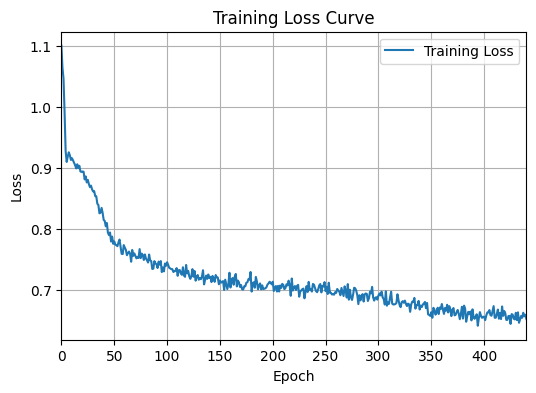

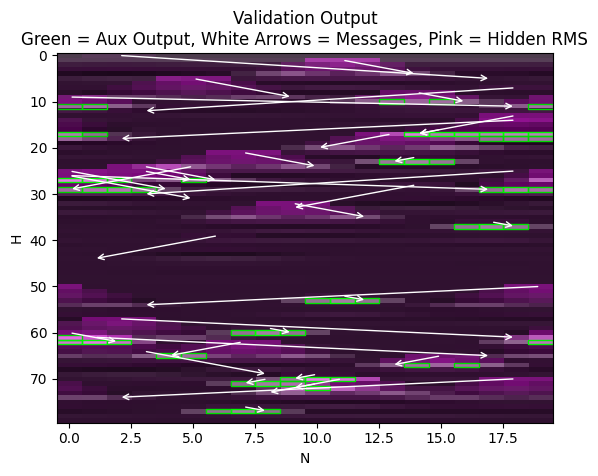

In [11]:
# Parameters
# H = height of scenario, i.e. maximum number of timesteps
# N = width of scenario, i.e. the length of the loop of nodes
# X = twice the maximum message delivery distance, i.e. X=10 will send messages a maximum distance of +-5
# C = number of channels that the model uses for its internal learned representations
# W = width of 1d convolution kernel, only W=3 makes sense really
# M = number of messages to send per scenario
# B = batch size
# lr = learning rate
#H, N, X, C, W, M, B = 128, 64, 16, 12, 5, 40, 128           # Dimensions and config
#H, N, X, C, W, M, B = 80, 40, 10, 10, 3, 40, 64  # best loss 0.0561
#H, N, X, C, W, M, B = 80, 40, 10, 8, 3, 40, 64   # best loss 0.0714
#H, N, X, C, W, M, B, lr = 160, 40, 40, 30, 3, 40, 64, 0.001
H, N, X, C, W, M, B, lr = 80, 20, 10, 10, 3, 40, 64, 0.01

# Create model
#model = DeepCNN(C, X, W, N, H, 0.05)
model = DeepGNN(C, X, W, N, H, 0.05)

# 1s are rare so we need to weight them in the loss function
pos_weight = ((H * N - M) / M) / 2
print(f"Positive weight: {pos_weight}")

# Train model until convergence
model = train_model_until_convergence(
    model,
    H=H, N=N, X=X, M=M,
    batch_size=B,
    lr=lr,
    pos_weight=pos_weight,
    patience=50,
    max_epochs=5000,
    l1_lambda=0.0001, # was 0.0001
    ignore_layers=5
)

# Generate validation input (new messages)
val_inputs, _ = generate_message_data(
    H, N, X, M, batch_size=1
)

# Inference, show 4 examples
val_outputs, hidden_rms = run_inference(model, val_inputs)

# Visualize result
visualize_validation_output(val_inputs, val_outputs, hidden_rms)
